In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Set Up Your Notebook and Load the Data

In [ ]:
# Load the dataset
# too big for github, download from: https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption
df = pd.read_csv(
    '.\\csv\\household_power_consumption.txt',
    sep=';',
    low_memory=False,
    parse_dates={'datetime': ['Date', 'Time']},
    na_values=['?']
) # type: ignore

# parse_dates={'datetime': ['Date', 'Time']}: Combines the Date and Time columns into a single datetime column.
# na_values=['?']: Replaces the '?' characters with NaN (Not a Number), which pandas recognizes as missing values.

C:\Users\minh.chau\AppData\Local\Temp\ipykernel_38716\1948150595.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


### Step 2: Handle Missing Values and Data Types

In [4]:
# Check for missing values
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Convert all columns to numeric types, except 'datetime'
for col in df.columns[1:]:
    df[col] = pd.to_numeric(df[col])

datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


### Step 3: Resample the Data

The data is at a minute-level, which is too granular for most analysis. Resample it to an hourly or daily frequency to create meaningful load profiles. Hourly is a great starting point for TOU analysis.

In [5]:
# Set the 'datetime' column as the index
df.set_index('datetime', inplace=True)

# Resample to hourly data, taking the mean of all columns
hourly_df = df.resample('H').mean()

# df.resample('H').mean(): This is a powerful pandas function that groups the data by hour ('H') and calculates the mean for each hour.

### Step 4: Visualize Daily Load Profiles

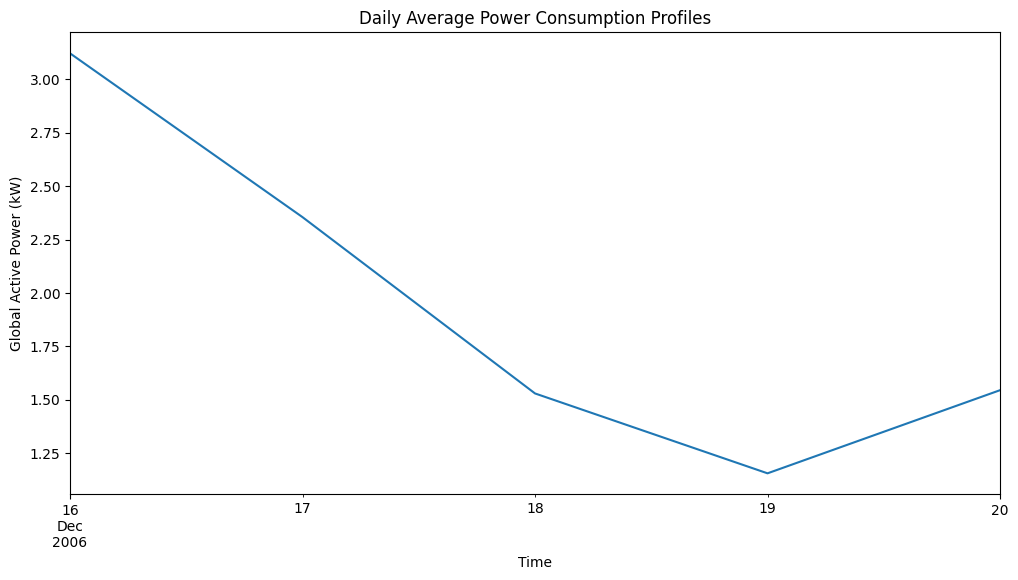

In [6]:
# Plot a few random days to see the patterns
daily_profiles = hourly_df['Global_active_power'].resample('D').mean()
daily_profiles.head(5).plot(figsize=(12, 6))
plt.title('Daily Average Power Consumption Profiles')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.show()

### Step 5: Prepare Data for Clustering

To perform clustering, you need to transform the data so that each row represents a single entity (a day) and the columns represent the features (e.g., hourly power consumption).

daily_profiles_df will have days as the index and hours (0 to 23) as columns, which is the perfect format for K-Means Clustering.

In [7]:
print("Current index type:", type(hourly_df.index))
print("Index sample:", hourly_df.index[:5])

Current index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index sample: DatetimeIndex(['2006-12-16 17:00:00', '2006-12-16 18:00:00',
               '2006-12-16 19:00:00', '2006-12-16 20:00:00',
               '2006-12-16 21:00:00'],
              dtype='datetime64[ns]', name='datetime', freq='H')


In [8]:
# Create proper MultiIndex for unstacking
hourly_df_fixed = hourly_df.copy()
hourly_df_fixed.index = pd.MultiIndex.from_arrays([
    hourly_df_fixed.index.date,
    hourly_df_fixed.index.hour
], names=['date', 'hour'])
hourly_df = hourly_df_fixed

In [9]:
# Create a new DataFrame where each row is a day and columns are the 24 hours
daily_profiles_df = hourly_df['Global_active_power'].unstack(level=0).T

In [10]:
# need to remove Nan otherwise KMeans will fail
daily_profiles_df.dropna(inplace=True)

### Step 6: Perform K-Means Clustering

Use the KMeans algorithm from scikit-learn to cluster the daily load profiles. You need to decide on the number of clusters (n_clusters). A good way to start is by trying 3 to 5 clusters, representing patterns like "Workday," "Weekend," and "High Consumption Day."

In [11]:
# use sihouette score to find the optimal number of clusters
from sklearn.cluster import KMeans

from sklearn.metrics import silhouette_score
silhouette_scores = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(daily_profiles_df)
    score = silhouette_score(daily_profiles_df, kmeans.labels_)
    silhouette_scores.append(score)

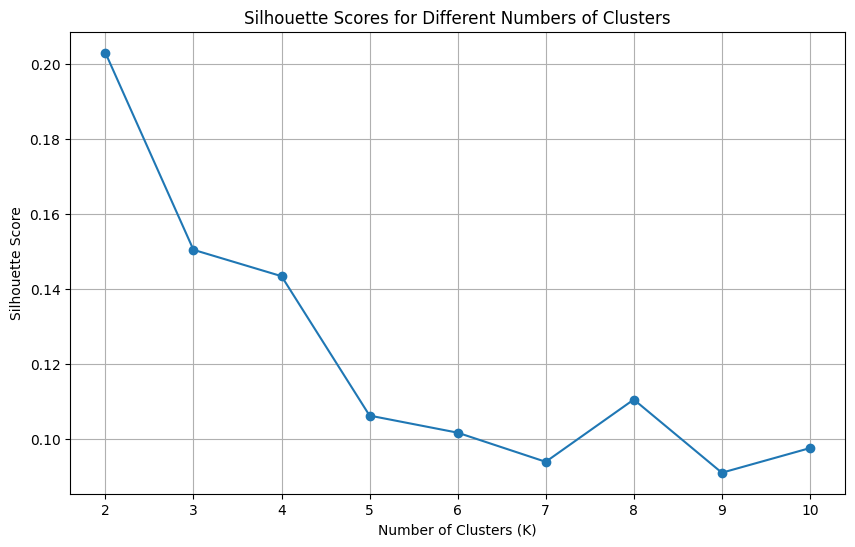

In [12]:
# plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(K, silhouette_scores, marker='o')
plt.title('Silhouette Scores for Different Numbers of Clusters')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(K)
plt.grid()
plt.show()

In [13]:
from sklearn.cluster import KMeans

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=5, random_state=0, n_init='auto')
clusters = kmeans.fit_predict(daily_profiles_df)

# Add the cluster labels back to the DataFrame
daily_profiles_df['Cluster'] = clusters

### Step 7: Analyze the Clusters

Visualizing the average load profile for each cluster.

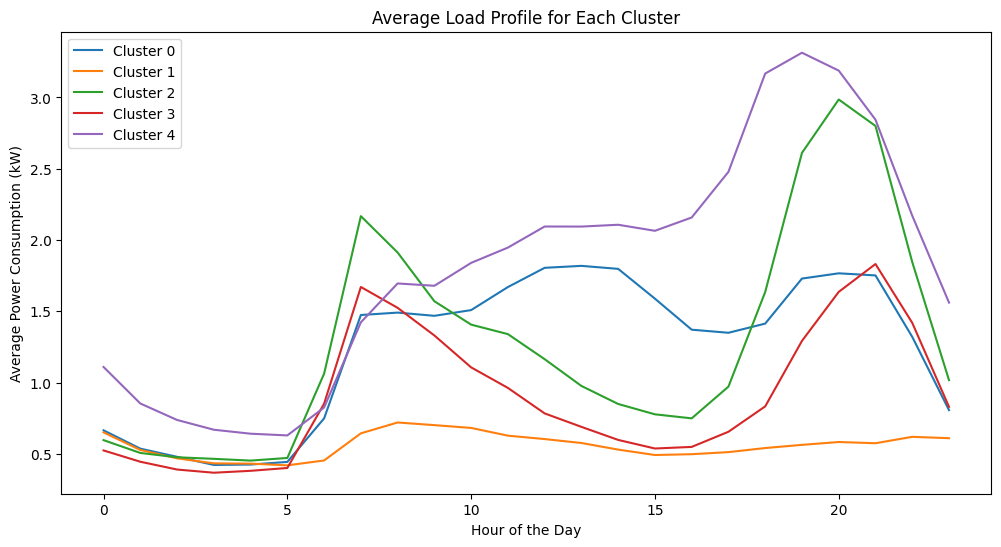

In [14]:
# Plot the average profile for each cluster
cluster_profiles = daily_profiles_df.groupby('Cluster').mean().T

plt.figure(figsize=(12, 6))
for i in range(len(cluster_profiles.columns)):
    plt.plot(cluster_profiles.iloc[:, i], label=f'Cluster {i}')
plt.title('Average Load Profile for Each Cluster')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Power Consumption (kW)')
plt.legend()
plt.show()

### Step 8 Pricing models simulations based on TOU

Define sample TOU based on peak, off-peak, shoulder hours


In [15]:
# Define hypothetical TOU periods
# Example: Peak hours are 5 PM to 9 PM (17:00-21:00)
def tou_period(hour):
    if 17 <= hour <= 21:
        return 'peak'
    else:
        return 'off-peak'

In [16]:
# Since 'hour' is now a level in your MultiIndex, access it directly
hourly_df['tou_period'] = hourly_df.index.get_level_values('hour').map(tou_period)

In [17]:
# Ensure the index is a DatetimeIndex for dayofweek extraction
daily_profiles_df.index = pd.to_datetime(daily_profiles_df.index)

# Add day_of_week and is_weekend columns
daily_profiles_df['day_of_week'] = daily_profiles_df.index.dayofweek
daily_profiles_df['is_weekend'] = daily_profiles_df['day_of_week'].isin([5, 6])

# Merge cluster labels back to the main DataFrame
# We do this by creating a mapping of day to cluster label
cluster_map = daily_profiles_df['Cluster'].to_dict()

# Map the cluster labels to the original hourly_df
# The first level of the MultiIndex is the date
hourly_df['cluster'] = hourly_df.index.get_level_values('date').map(cluster_map)

In [18]:
# Apply the function to create a new column
hourly_df['tou_period'] = hourly_df.index.get_level_values('hour').map(tou_period)

# Check for rows with NaN cluster values, which might happen if you have missing data.
# It's good practice to drop or fill these before proceeding.
hourly_df.dropna(subset=['cluster'], inplace=True)
hourly_df['cluster'] = hourly_df['cluster'].astype(int)

# Group by cluster and TOU period to find the average consumption
consumption_by_period = hourly_df.groupby(['cluster', 'tou_period'])['Global_active_power'].mean().unstack()


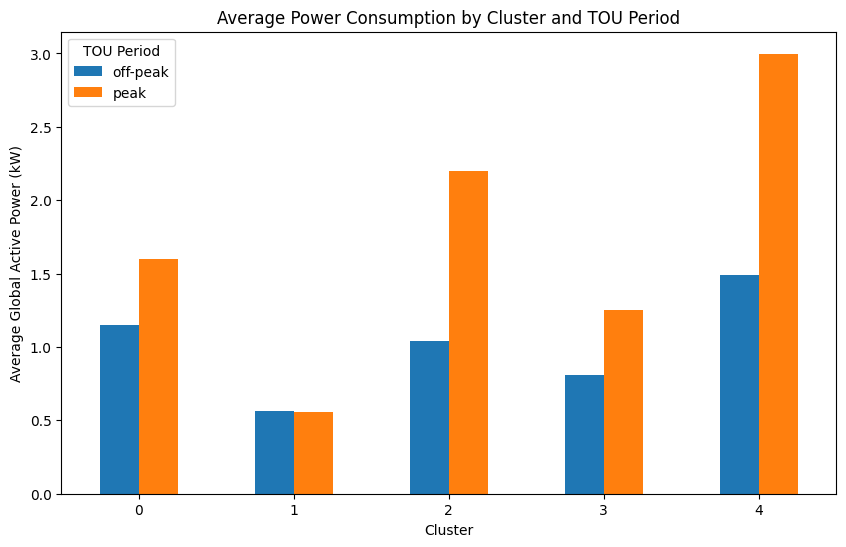

In [19]:

# Plot the results to visualize the different consumption patterns
consumption_by_period.plot(kind='bar', figsize=(10, 6), title='Average Power Consumption by Cluster and TOU Period')
plt.ylabel('Average Global Active Power (kW)')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.legend(title='TOU Period')
plt.show()

#### SIMULATE pricing models to compare between those, if possible, choose the most optimal one per load profile?

In [20]:
# Define pricing parameters
CUSTOM_PRICING_MODELS = {
    'flat_rate': {
        'rate': 0.15,  # $/kWh
        'description': 'Fixed rate for all hours'
    },
    'tou_basic': {
        'peak_rate': 0.25,      # $/kWh (5PM-9PM)
        'off_peak_rate': 0.10,  # $/kWh (all other hours)
        'peak_hours': list(range(17, 22)),  # 5PM to 9PM
        'description': 'Simple peak/off-peak pricing'
    },
    'tou_advanced': {
        'peak_rate': 0.28,      # $/kWh (4PM-9PM)
        'shoulder_rate': 0.18,  # $/kWh (7AM-4PM, 9PM-11PM)
        'off_peak_rate': 0.08,  # $/kWh (11PM-7AM)
        'peak_hours': list(range(16, 21)),     # 4PM to 9PM
        'shoulder_hours': list(range(7, 16)) + list(range(21, 23)),  # 7AM-4PM, 9PM-11PM
        'off_peak_hours': list(range(0, 7)) + [23],  # 12AM-7AM, 11PM
        'description': 'Three-tier TOU pricing'
    },
    'demand_charge': {
        'energy_rate': 0.12,    # $/kWh
        'demand_rate': 15.0,    # $/kW per month (peak demand)
        'description': 'Energy + demand charge pricing'
    }
}
CUSTOM_TOU_PERIODS = {
    'peak_hours': list(range(17, 22)),  # 5 PM to 9 PM
    'shoulder_hours': list(range(7, 17)) + list(range(22, 24)),  # 7AM-5PM, 10PM-midnight
    'off_peak_hours': list(range(0, 7))  # Midnight to 7 AM
}

In [21]:
from pricing_simulator import analyze_cluster_pricing, plot_cluster_pricing_analysis


In [22]:
# Analyze pricing with custom models
cluster_pricing_results = analyze_cluster_pricing(
    daily_profiles_df, 
    cluster_column='Cluster',
    pricing_models=CUSTOM_PRICING_MODELS,
    tou_periods=CUSTOM_TOU_PERIODS,
    models_to_compare=['flat_rate', 'tou_basic', 'tou_advanced', 'demand_charge']
)


Analyzing Cluster 4...
Analyzing Cluster 2...
Analyzing Cluster 0...
Analyzing Cluster 3...
Analyzing Cluster 1...


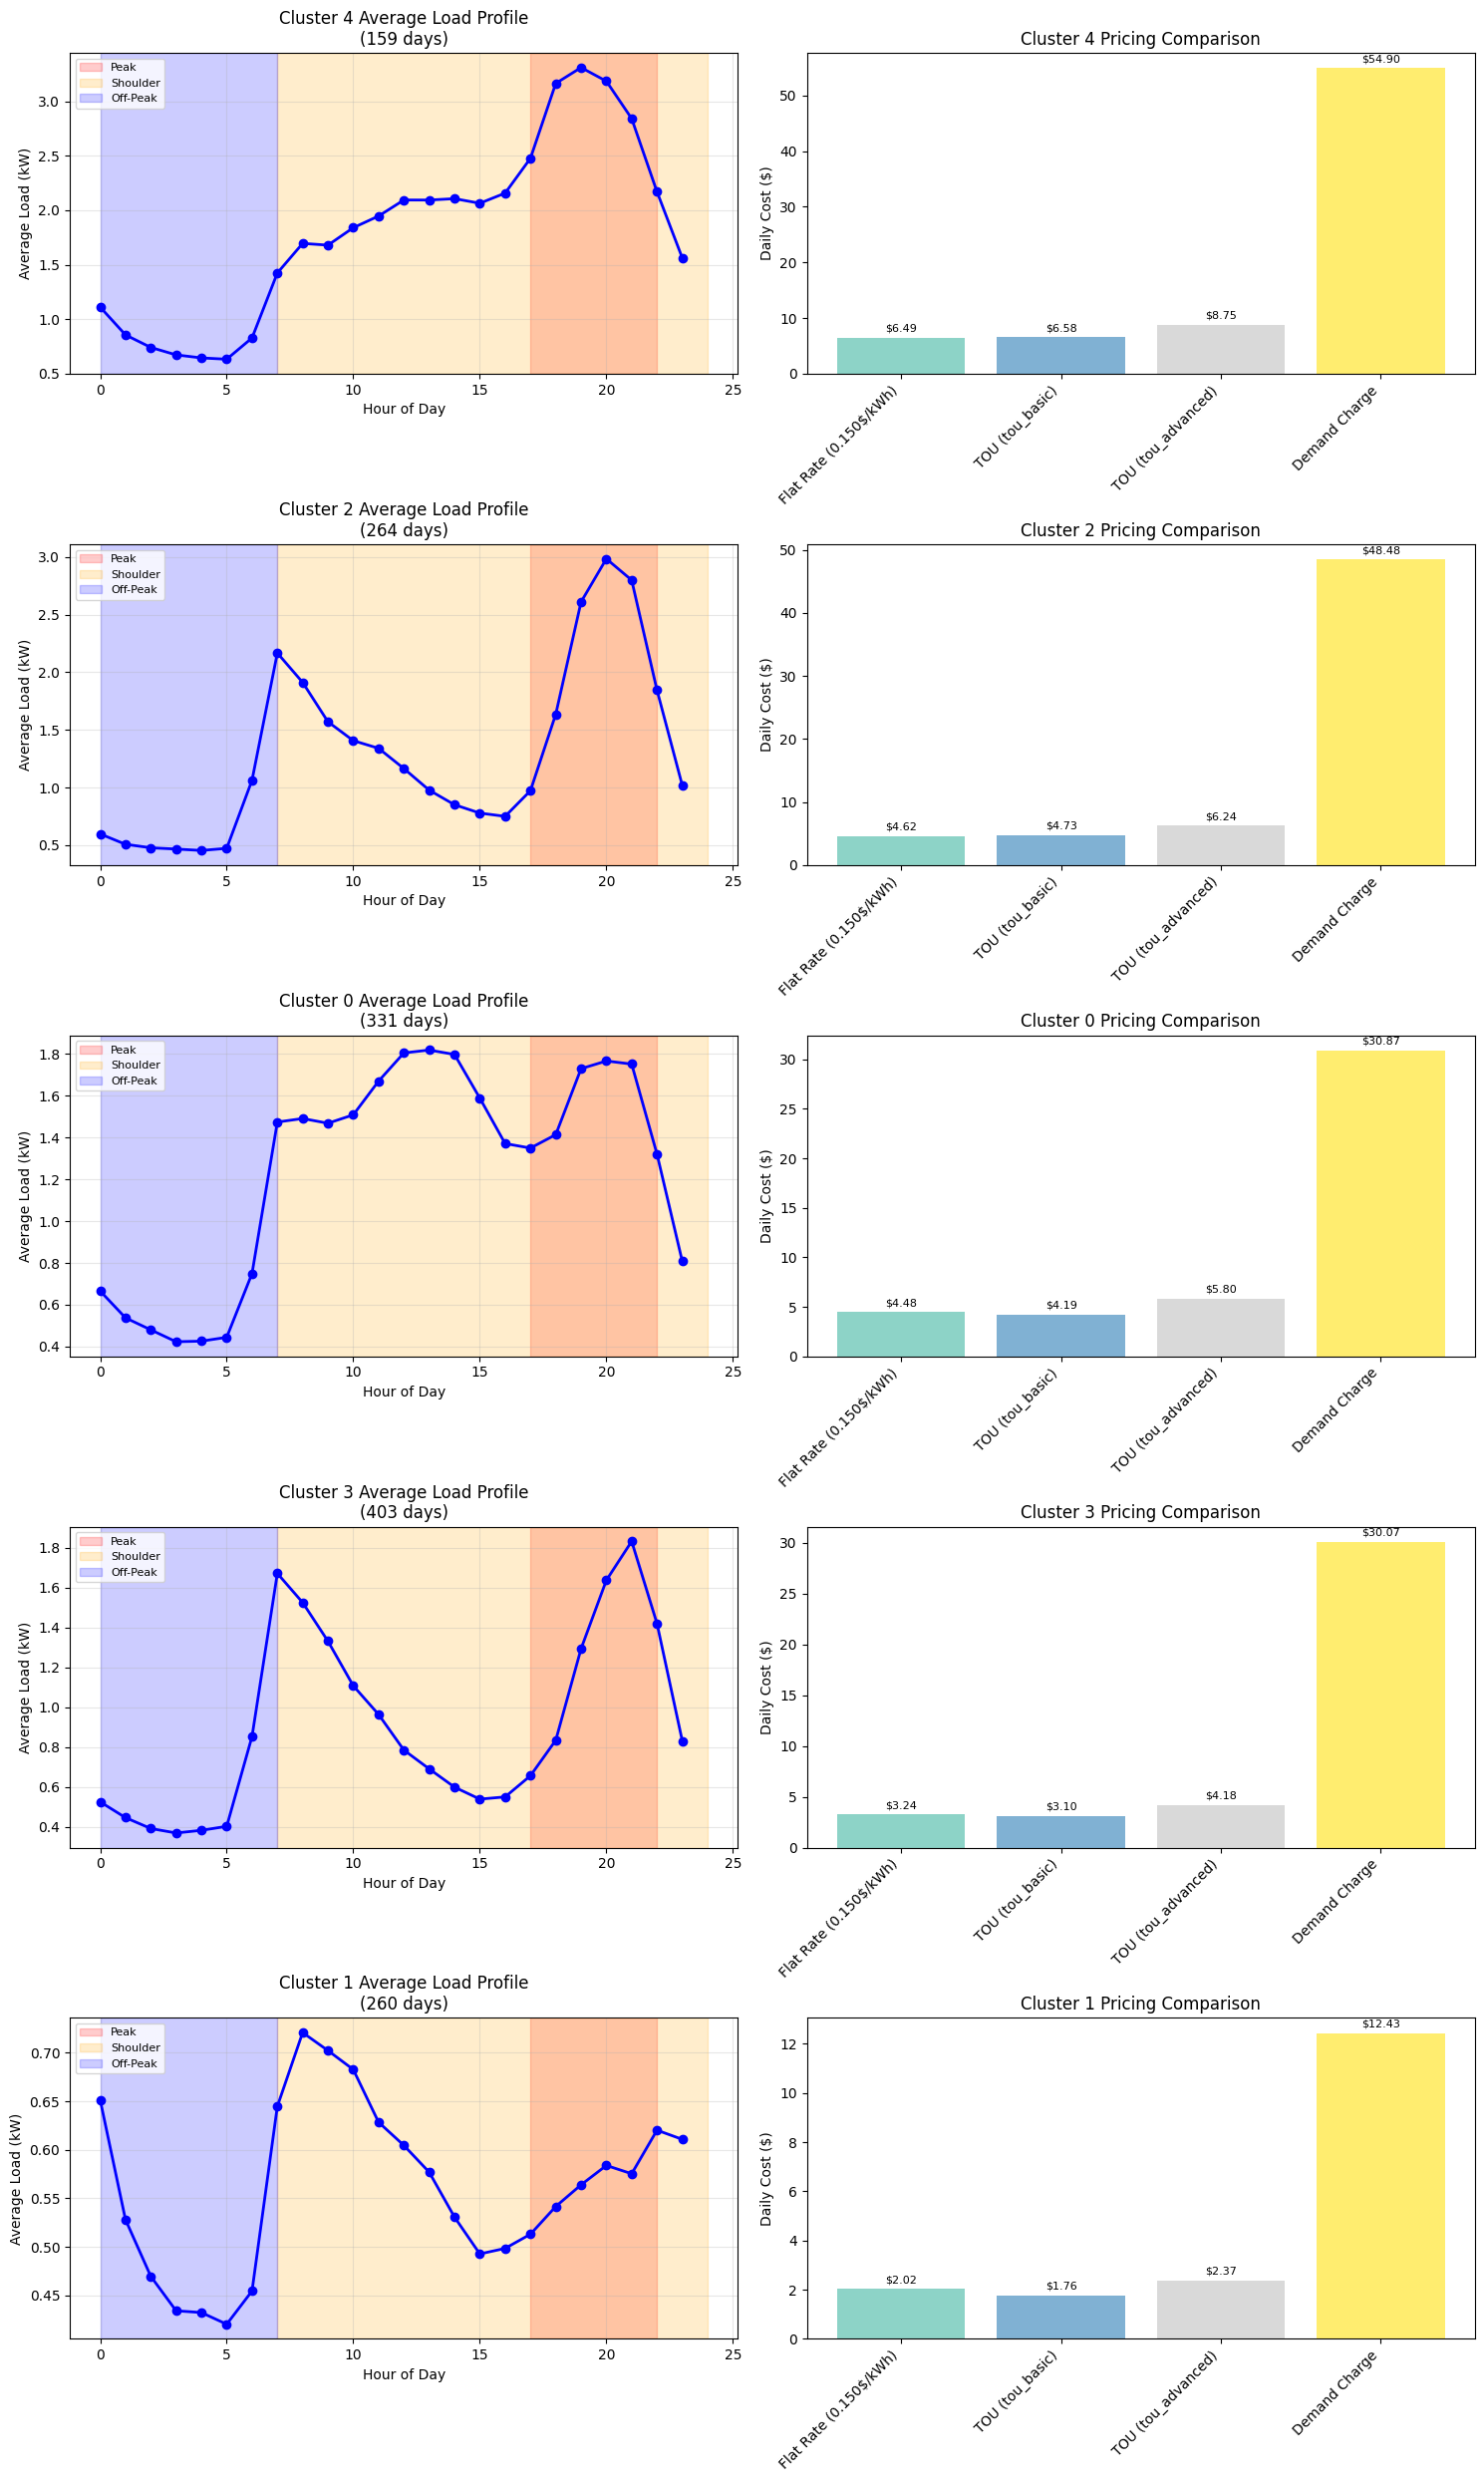


CLUSTER 4 PRICING ANALYSIS
                    Model  Total Cost ($)  Energy Cost ($)  Demand Cost ($)  \
0  Flat Rate (0.150$/kWh)           6.495            6.495            0.000   
1         TOU (tou_basic)           6.578            6.578            0.000   
2      TOU (tou_advanced)           8.746            8.746            0.000   
3           Demand Charge          54.897            5.196           49.701   

   Savings vs Base ($)  Savings vs Base (%)  
0                0.000                0.000  
1               -0.084               -1.290  
2               -2.251              -34.660  
3              -48.402             -745.263  

CLUSTER 2 PRICING ANALYSIS
                    Model  Total Cost ($)  Energy Cost ($)  Demand Cost ($)  \
0  Flat Rate (0.150$/kWh)           4.623            4.623            0.000   
1         TOU (tou_basic)           4.733            4.733            0.000   
2      TOU (tou_advanced)           6.245            6.245            0.000   
3 

In [23]:
# Plot the results
plot_cluster_pricing_analysis(cluster_pricing_results)

# Print detailed results
for cluster_id, results in cluster_pricing_results.items():
    print(f"\n{'='*50}")
    print(f"CLUSTER {cluster_id} PRICING ANALYSIS")
    print(f"{'='*50}")
    print(results['comparison_df'].round(3))

##### let use some reference EU market model

In [24]:
# Updated pricing models based on real EU examples
EU_REALISTIC_PRICING_MODELS = {
    'germany_standard': {
        'rate': 0.32,  # €/kWh
        'description': 'German standard household tariff (2024)'
    },
    'france_blue_day': {
        'peak_rate': 0.20,      # €/kWh (6AM-10PM)
        'off_peak_rate': 0.16,  # €/kWh (10PM-6AM)
        'description': 'France EDF Tempo - Blue day'
    },
    'france_red_day': {
        'peak_rate': 0.76,      # €/kWh (6AM-10PM) - VERY EXPENSIVE!
        'off_peak_rate': 0.17,  # €/kWh (10PM-6AM)
        'description': 'France EDF Tempo - Red day (critical demand)'
    },
    'netherlands_capacity': {
        'energy_rate': 0.08,    # €/kWh
        'demand_rate': 3.75,    # €/kW/month (45€/kW/year ÷ 12)
        'description': 'Netherlands capacity-based pricing'
    },
    'spain_valley': {
        'valley_rate': 0.12,    # €/kWh (valleys: 0-8h, 14-18h, 22-24h)
        'flat_rate': 0.16,     # €/kWh (flats: 8-10h, 18-22h)
        'peak_rate': 0.20,     # €/kWh (peaks: 10-14h)
        'description': 'Spain PVPC three-period pricing'
    }
}

EU_TOU_PERIODS = {
    'standard_eu': {
        'peak_hours': list(range(6, 22)),    # 6AM-10PM (most EU countries)
        'off_peak_hours': list(range(22, 24)) + list(range(0, 6))  # 10PM-6AM
    },
    'spain_pvpc': {
        'valley_hours': list(range(0, 8)) + list(range(14, 18)) + list(range(22, 24)),
        'flat_hours': list(range(8, 10)) + list(range(18, 22)),
        'peak_hours': list(range(10, 14))
    }
}


In [25]:
# Import the functions from pricing_simulator
from pricing_simulator import (
    analyze_with_eu_pricing, 
    plot_eu_pricing_analysis, 
    print_eu_pricing_results
)

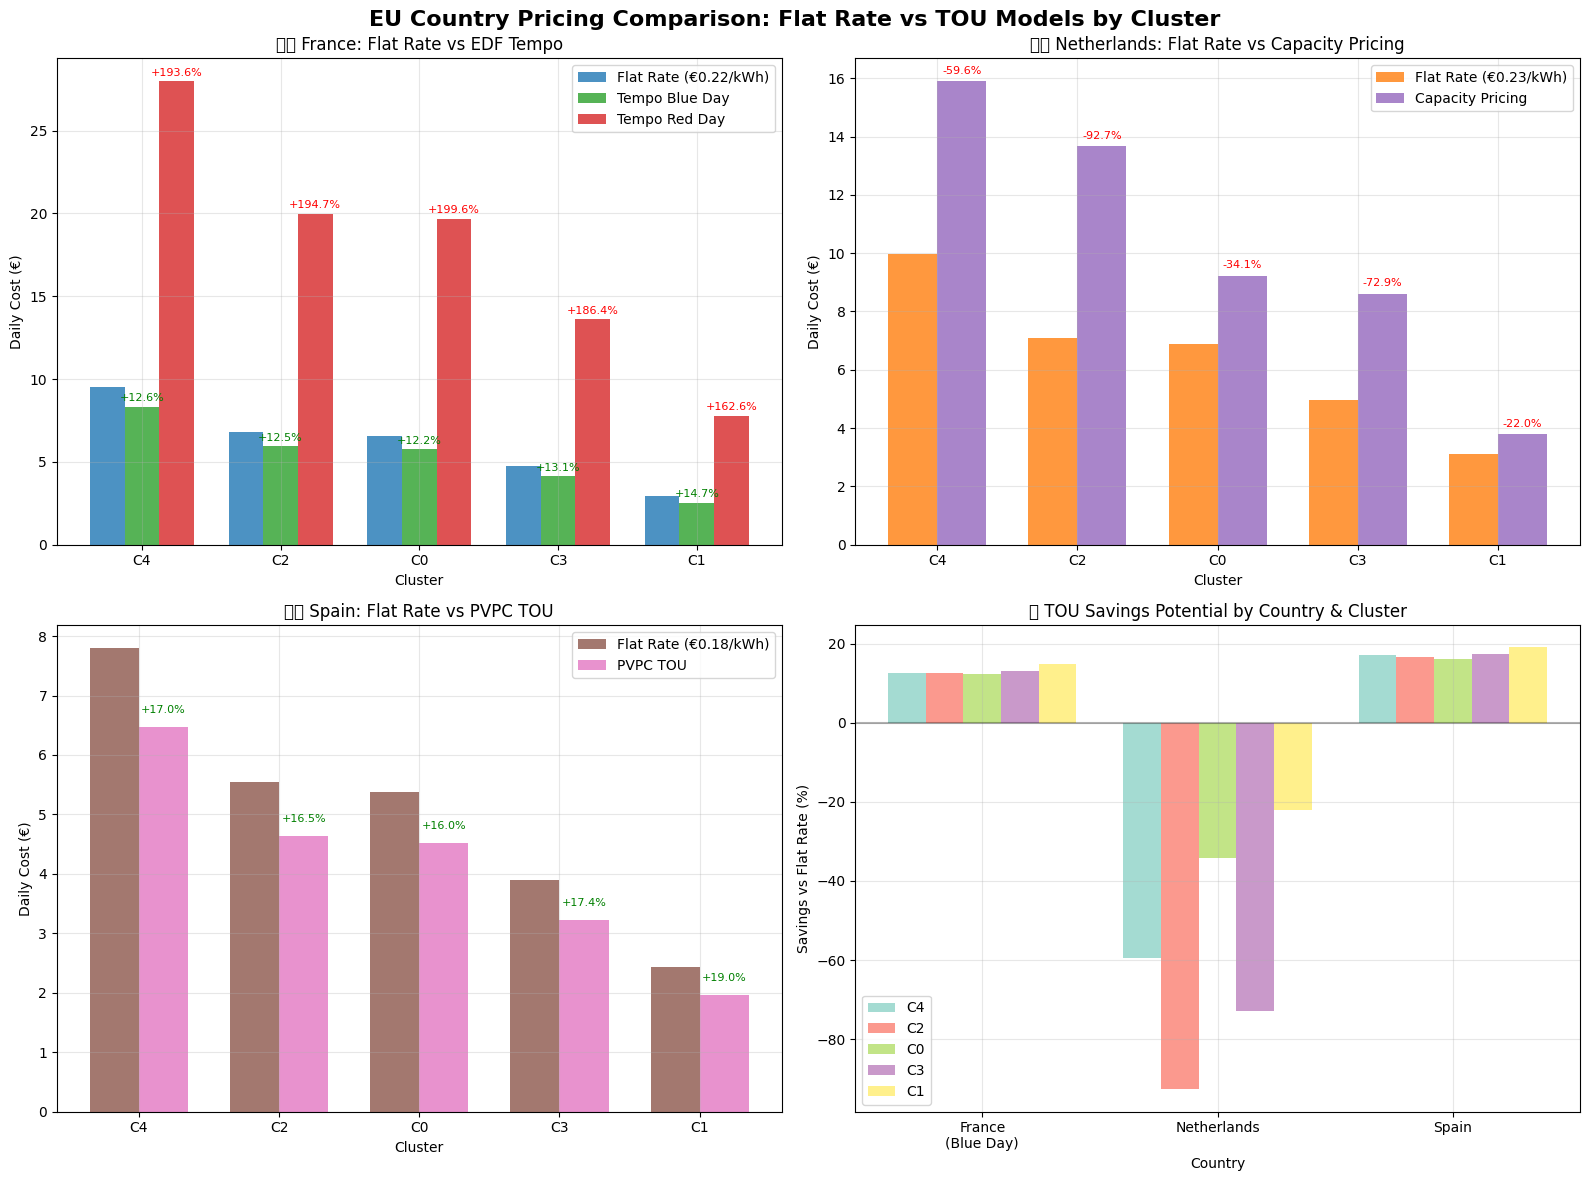

=== EU COUNTRY-SPECIFIC PRICING ANALYSIS ===
Comparing flat rate vs TOU models within each country

🔹 CLUSTER 4 (159 days)
   Daily consumption: 43.30 kWh
   Peak demand: 3.31 kW

🇩🇪 GERMANY:
   • Flat rate only: €13.86/day
   • Germany primarily uses flat rate pricing

🇫🇷 FRANCE (EDF Tempo):
   • Flat rate baseline: €9.53/day
   • Blue day Tempo: €8.32/day (savings: +12.6%)
   • Red day Tempo: €27.96/day (penalty: +193.6%)
🔹 CLUSTER 2 (264 days)
   Daily consumption: 30.82 kWh
   Peak demand: 2.99 kW

🇩🇪 GERMANY:
   • Flat rate only: €9.86/day
   • Germany primarily uses flat rate pricing

🇫🇷 FRANCE (EDF Tempo):
   • Flat rate baseline: €6.78/day
   • Blue day Tempo: €5.93/day (savings: +12.5%)
   • Red day Tempo: €19.98/day (penalty: +194.7%)
🔹 CLUSTER 0 (331 days)
   Daily consumption: 29.86 kWh
   Peak demand: 1.82 kW

🇩🇪 GERMANY:
   • Flat rate only: €9.56/day
   • Germany primarily uses flat rate pricing

🇫🇷 FRANCE (EDF Tempo):
   • Flat rate baseline: €6.57/day
   • Blue day Tem

In [31]:
import warnings
warnings.filterwarnings('ignore')

# Run the analysis
eu_results = analyze_with_eu_pricing(
    daily_profiles_df, 
    EU_REALISTIC_PRICING_MODELS, 
    EU_TOU_PERIODS, 
    cluster_column='Cluster'
)

# Plot the results
plot_eu_pricing_analysis(eu_results, EU_TOU_PERIODS)

# Print detailed results
print_eu_pricing_results(eu_results)

### Step 9 - TOU optimization simulation

In [27]:
# Examine specific cluster optimization results
cluster_to_analyze = 4  # Change this to analyze different clusters
pricing_model_to_analyze = 'tou_advanced'  # or 'tou_basic', 'demand_charge'


In [28]:
from tou_optimization import (
    analyze_cluster_optimization,
    plot_optimization_results,
    create_optimization_summary,
    plot_optimization_summary,
    print_optimization_recommendations
)

Running TOU optimization analysis...
Optimization Summary:
   Cluster  Pricing_Model Optimization_Method  Baseline_Cost  Optimized_Cost  \
0        4      tou_basic       load_shifting       6.578416        5.903818   
1        4      tou_basic     battery_storage       6.578416        5.561729   
2        4      tou_basic     demand_response       6.578416        5.735168   
3        4   tou_advanced       load_shifting       8.520945        7.880841   
4        4   tou_advanced     battery_storage       8.520945        7.346857   
5        4   tou_advanced     demand_response       8.520945        7.619709   
6        4  demand_charge       load_shifting       6.494632        6.494632   
7        4  demand_charge     battery_storage       6.494632        7.674158   
8        4  demand_charge     demand_response       6.494632        5.988683   
9        2      tou_basic       load_shifting       4.732909        4.237684   

      Savings_$     Savings_%  Cluster_Size  
0  6.745984e-0

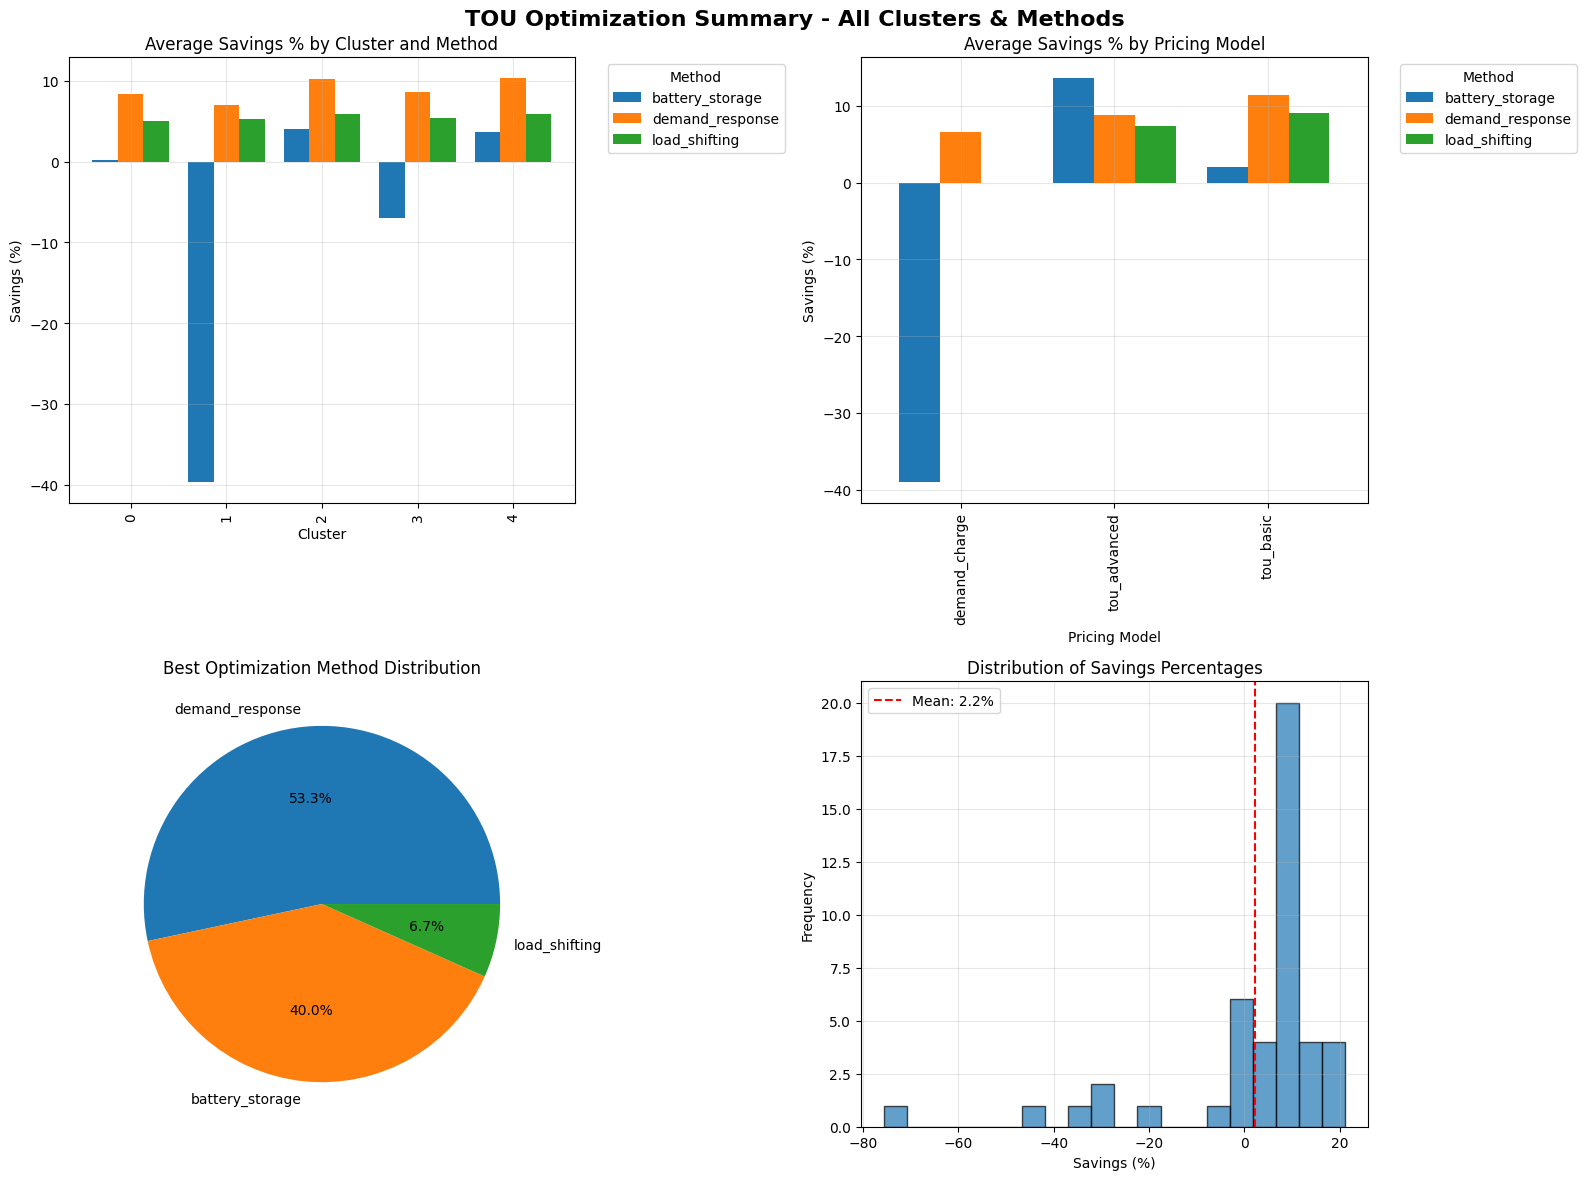

=== TOU OPTIMIZATION RECOMMENDATIONS ===

🔹 CLUSTER 4 (159 days)
   Average daily consumption: 43.30 kWh
   Peak demand: 3.31 kW

   📊 TOU_BASIC:
      • Load Shifting: 10.3% ($0.67/day)
      • Battery Storage: 15.5% ($1.02/day)
      • Demand Response: 12.8% ($0.84/day)
      ⭐ Best: Battery Storage

   📊 TOU_ADVANCED:
      • Load Shifting: 7.5% ($0.64/day)
      • Battery Storage: 13.8% ($1.17/day)
      • Demand Response: 10.6% ($0.90/day)
      ⭐ Best: Battery Storage

   📊 DEMAND_CHARGE:
      • Load Shifting: 0.0% ($0.00/day)
      • Battery Storage: -18.2% ($-1.18/day)
      • Demand Response: 7.8% ($0.51/day)
      ⭐ Best: Demand Response

   🏆 RECOMMENDATION: tou_basic with battery storage 
       💰 Potential savings: 15.5% ($1.02/day)
       📅 Annual savings: $371


🔹 CLUSTER 2 (264 days)
   Average daily consumption: 30.82 kWh
   Peak demand: 2.99 kW

   📊 TOU_BASIC:
      • Load Shifting: 10.5% ($0.50/day)
      • Battery Storage: 20.4% ($0.96/day)
      • Demand Response

In [29]:

# Run TOU optimization analysis
print("Running TOU optimization analysis...")
optimization_results = analyze_cluster_optimization(
    daily_profiles_df,
    CUSTOM_PRICING_MODELS,
    CUSTOM_TOU_PERIODS,
    cluster_column='Cluster'
)

# Create and display summary
summary_df = create_optimization_summary(optimization_results)
print("Optimization Summary:")
print(summary_df.head(10))

# Plot summary results
plot_optimization_summary(summary_df)

# Print recommendations
print_optimization_recommendations(optimization_results)